# Practice with Callbacks and off-axis geometry

This notebook will get you working with callbacks as well as thinking through 3D geometries. 

The goal is to use `IsolatedGalaxy` and make the following off-axis slice plot:

![](figures/Callbacks_nice_slice.png)



To **exactly** recreate the figure, you'll need to create an **off-axis slice** with the following features:
* a ray passing through the maximum density value of the dataset with the following characteristics (drawn on the sliceplot with `annotate_ray`):
    * ray length is .5 in units of `code_length`
    * The maximum density value is at the center point of the ray
    * The ray direction points from the domain's left edge to the maximum density value 
* the off-axis slice is oriented such that the entirety of the ray lies within the slicing plane (calculate and use any normal vector perpendicular to the ray) with a slice width of 0.5 Mpc and centered on the maximum density value
* The ray start is indicated by the X marker, ray end is indicated by the circle, both added with `annotate_marker`
* in-plane velocities are overlaid with `annotate_cquiver`
* temperature contours are overlaid with `annotate_contour`

The documentation page for callbacks may be helpful to you: https://yt-project.org/doc/visualizing/callbacks.html

### Ok, let's load in a dataset:

In [1]:
import yt 
import numpy as np 
ds = yt.load_sample("IsolatedGalaxy")
field = ('gas', 'density')

yt : [INFO     ] 2025-07-14 12:10:21,906 Sample dataset found in '/home/chavlin/data/yt_data/yt_sample_sets/IsolatedGalaxy/galaxy0030/galaxy0030'
yt : [INFO     ] 2025-07-14 12:10:22,105 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2025-07-14 12:10:22,106 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-07-14 12:10:22,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-14 12:10:22,108 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-14 12:10:22,109 Parameters: cosmological_simulation   = 0


### Setting up the ray 

First, find the location of the maximum density value:

In [2]:
# find the maximum 
ad = ds.all_data()
max_val_location = ad.quantities.max_location(field)
max_val_location

Parsing Hierarchy : 100%|██████████████████| 173/173 [00:00<00:00, 13697.30it/s]
yt : [INFO     ] 2025-07-14 12:10:22,144 Gathering a field list (this may take a moment.)


[unyt_quantity(7.73426504e-24, 'g/cm**3'),
 unyt_quantity(0.50408936, 'code_length'),
 unyt_quantity(0.49981689, 'code_length'),
 unyt_quantity(0.50018311, 'code_length')]

In [3]:
location = ds.arr([max_val_location[indx] for indx in range(1,4)])
location

unyt_array([0.50408936, 0.49981689, 0.50018311], 'code_length')

Now, construct a `ds.ray` object with the following characteristics:

* total length 0.5 in `'code_length'` units
* the maximum density value is located half-way along the ray
* the ray points from the `ds.domain_left_edge` to the maximum density value
  

In [4]:
# make a ray that passes through the max value and continues some distance

# the desired length of a ray
ray_length = ds.quan(0.5, 'code_length')

# calculate a unit-normal ray direction pointing from the 
# domain left edge to the maximum density value
ray_start = ds.domain_left_edge
ray_dir = (location - ray_start)
ray_dir = ray_dir / np.linalg.norm(ray_dir)

# calculate the ray start and end point 
ray_start = location - ray_length/2 * ray_dir
ray_end = location + ray_length/2 * ray_dir

r = ds.ray(ray_start, ray_end)
r.start_point, r.end_point

(unyt_array([0.35896801, 0.35592554, 0.35618632], 'code_length'),
 unyt_array([0.6492107 , 0.64370825, 0.64417989], 'code_length'))

### Building the slice 

To create off-axis slice that contains the entirety of the ray, we need the image-plane of the slice to be parallel to the ray -- or in other words, the normal vector for the image plane must be orthogonal to our ray. 

Since our ray is a line there are an infinite number of vectors that are orthoganl, so let's just pick one by setting the 1st and 2nd vector components and calculating the 3rd such that it makes the vector perpendicular to our ray: 


In [5]:
# set a dummy value, we'll keep the first two components 
# and then calculate the third
normal = ds.arr([1., 1., 1], 'code_length')
normal = normal / np.linalg.norm(normal)


# calculate the third component so that we get a perpendicular 
# vector (remember that a dot product between two vectors is 0 
# if they are perpedicular)
normal[2] = - (ray_dir[0] * normal[0] + ray_dir[1] * normal[1]) / ray_dir[2]

Now let's plot our initial slice with the normal vector we just calculated and a plot width of .5 'Mpc'. Also use `annotate_ray` to also plot our ray:

yt : [INFO     ] 2025-07-14 12:10:23,289 xlim = -0.249974 0.249974
yt : [INFO     ] 2025-07-14 12:10:23,290 ylim = -0.249974 0.249974
yt : [INFO     ] 2025-07-14 12:10:23,292 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



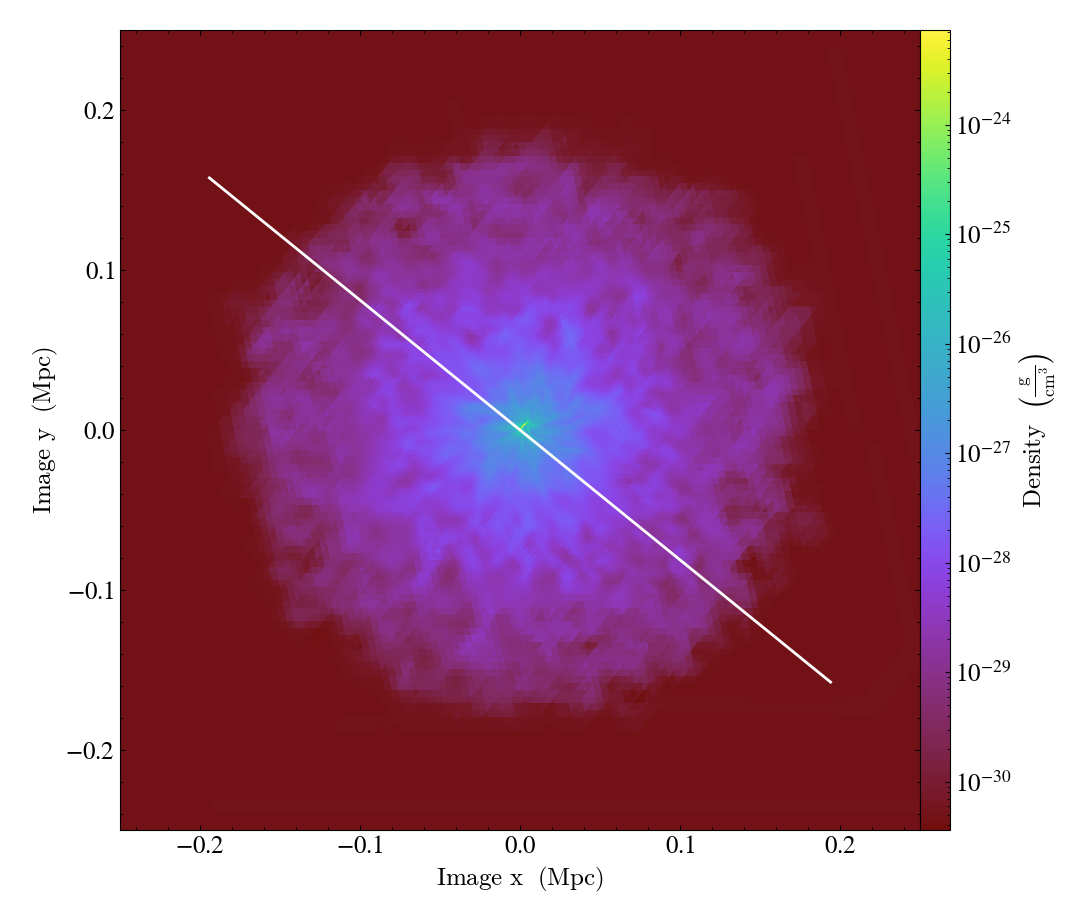

In [6]:
slc = yt.SlicePlot(ds, normal, 
                   field, 
                   center=location, 
                   width=(.5, 'Mpc'))
slc.annotate_ray(r)
slc.show()

But which direction is the ray pointing? Use `annotate_marker` to add two points: use `marker='x'` (the default) for the start point and `marker='o'` for the end point:


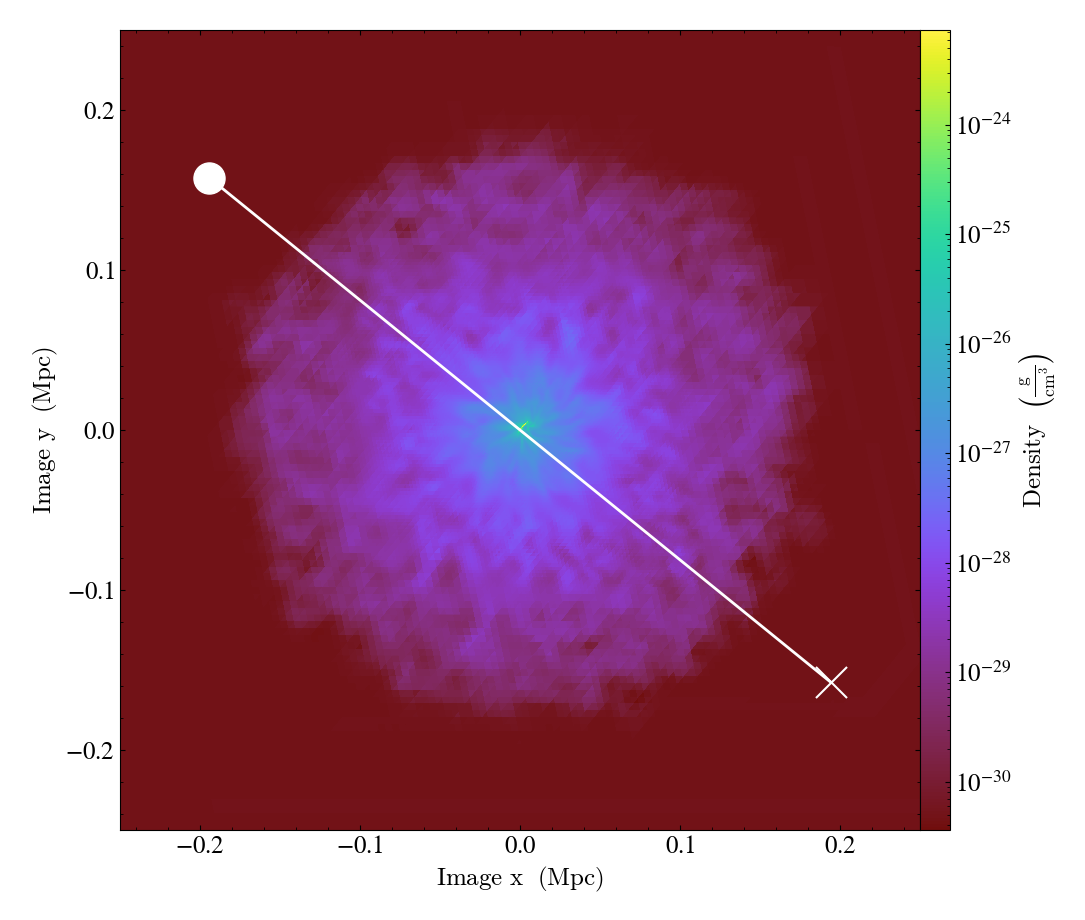

In [7]:
slc.annotate_marker(ray_end, marker="o", color="white", s=500)
slc.annotate_marker(ray_start, color="white", s=500)
slc.show()

Now let's add a few more overplotted data elements: use `annotate_contour` to plot contours of the temperature field:


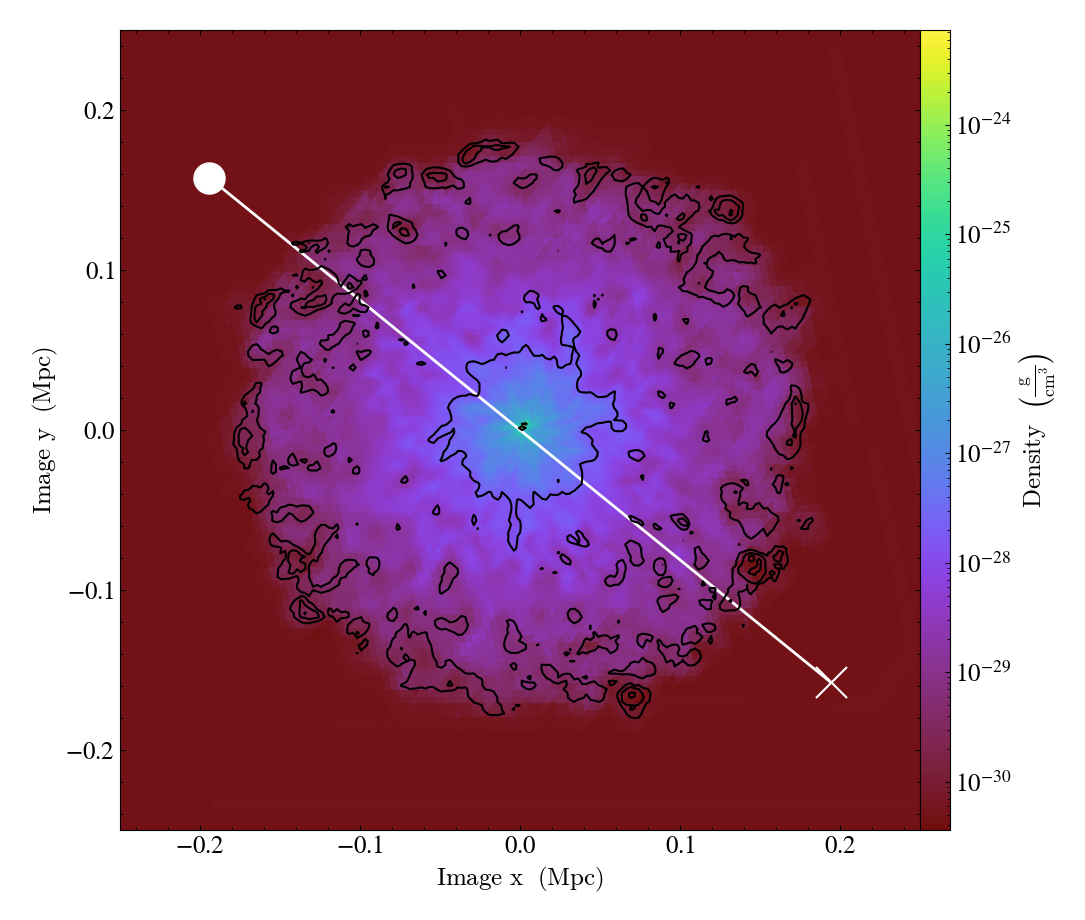

In [8]:
slc.annotate_contour(('gas', 'temperature'))
slc.show()

And let's also plot the in-plane velocity vectors (see https://yt-project.org/doc/visualizing/callbacks.html#annotate_cquiver): 


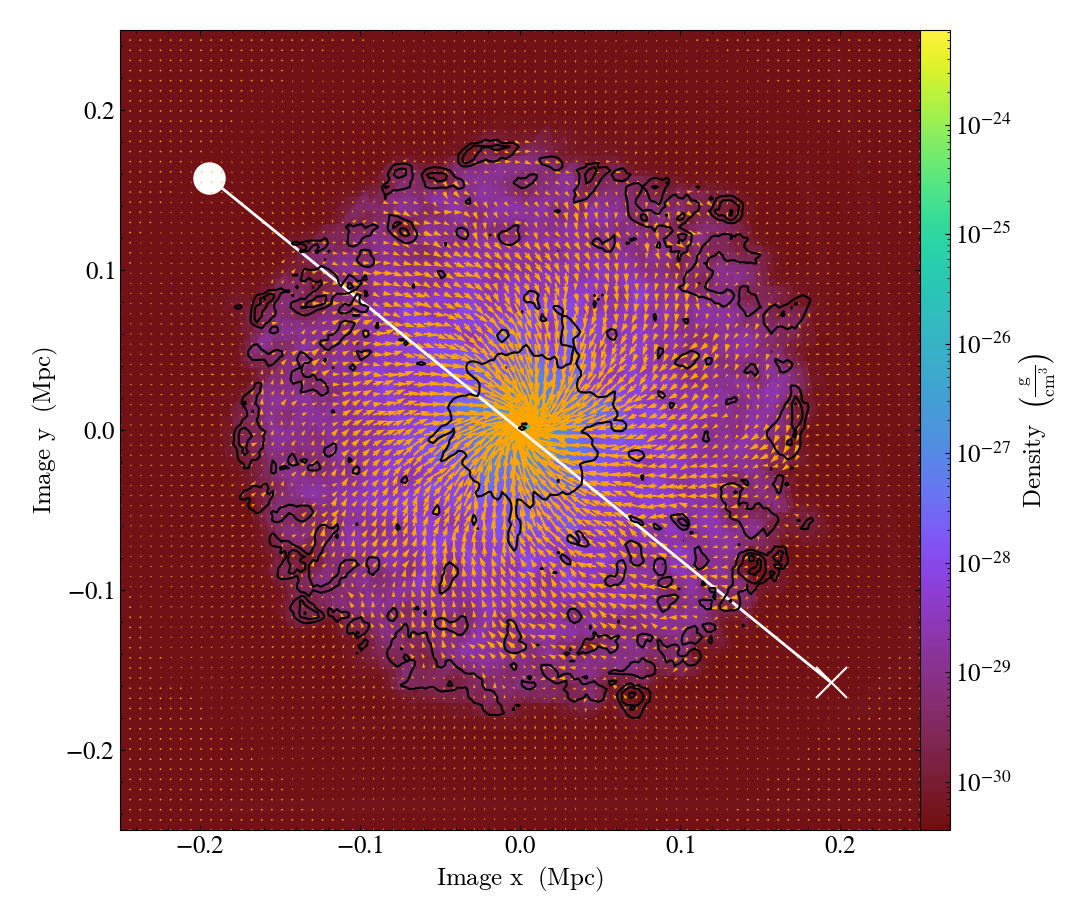

In [9]:
slc.annotate_cquiver(
    ("gas", "cutting_plane_velocity_x"),
    ("gas", "cutting_plane_velocity_y"),
    factor=10,
    color="orange",
)
slc.show()

### Bonus plots

For good measure, use a `yt.LinePlot` to plot both the density and temperature along the ray, which should end up looking like:

![](figures/Callbacks_den_prof.png)
![](figures/Callbacks_temp_prof.png)

yt : [INFO     ] 2025-07-14 12:10:29,480 Saving plot figures/Callbacks_den_prof.png
yt : [INFO     ] 2025-07-14 12:10:29,593 Saving plot figures/Callbacks_temp_prof.png



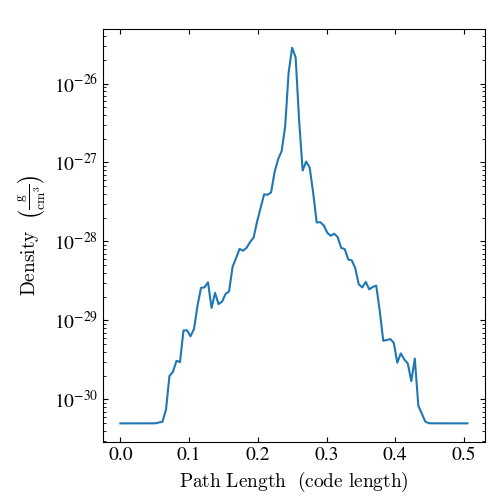
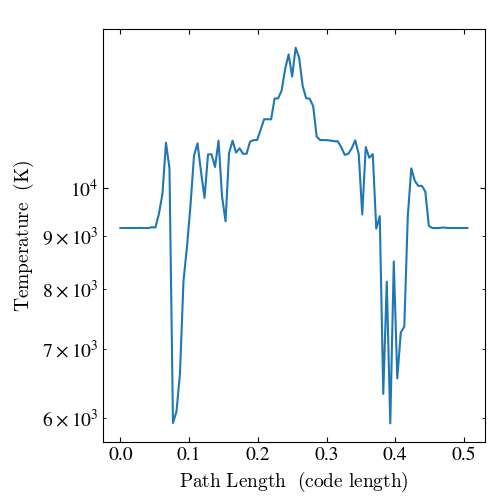

In [10]:
lp = yt.LinePlot(ds, [('gas', 'density'), ('gas', 'temperature')], r.start_point, r.end_point, 100)
lp[('gas', 'density')].save('figures/Callbacks_den_prof.png')
lp[('gas', 'temperature')].save('figures/Callbacks_temp_prof.png')
lp.show()

## Extra credit

Not ready to move on to the next notebook? Try orienting the plot so that the ray is in plane and oriented horizontally in the image (hint, use the `north_vector` argument for `SlicePlot`). 